In [4]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

seconds_per_day=60.*60.*24.
seconds_per_year=365.*seconds_per_day
carbon_molar_mass=12.011
cobalt_c_2_n = 106./16.

In [5]:
path_root='/archive/Jessica.Luo/gz_test/MOM6_SIS2_COBALT'

case,machine_target='OM4p5_CORE2_IAF_COBALT_abio_csf_mle200','gfdl.ncrc4-intel16-prod'

case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-082620','gfdl.ncrc4-intel16-prod'
#case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-082620_b','gfdl.ncrc4-intel16-prod'
#case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-082620_c','gfdl.ncrc4-intel16-prod'
#case,machine_target='OM4p5_CORE2_IAF_gzCOBALT-082620_d','gfdl.ncrc4-intel16-prod'


In [6]:
short_casename=case.replace('OM4p5_CORE2_IAF_','')
short_casename

'gzCOBALT-082620'

In [7]:
phyto_varlist = ['di', 'smp', 'lgp']
#zoo_varlist = ['smz', 'mdz', 'lgz']
zoo_varlist = ['smz', 'mdz', 'lgz', 'smt', 'lgt']

In [8]:
tmpdir = '/work/Jessica.Luo/tmp/'+case
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)
    print('created directory: '+tmpdir)
else:
    print('temporary directory exists: '+tmpdir)

temporary directory exists: /work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620


In [36]:
# read in files
diagTypes = ['ocean_cobalt_omip_tracers_month_z', 'ocean_cobalt_fluxes_int', 'ocean_cobalt_fdet_100', 'ocean_cobalt_tracers_int'] 

pp_dates='1988-2007'

files=[glob(tmpdir + '/'+ d + '.' + pp_dates + '*.nc') for d in diagTypes]

files=sorted([f for fi in files for f in fi]) # nested list comprehension
print(files)

['/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.01.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.02.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.03.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.04.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.05.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.06.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.07.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.08.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.09.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-082620/ocean_cobalt_fdet_100.1988-2007.10.nc', '/work/Jessica.Luo/tmp/OM4p5_CORE2_IAF_gzCOBALT-0

In [37]:
if not files:
    pp_path=os.path.join(path_root, case, machine_target, 'pp')
    
    files=[glob(pp_path + '/' + d + '/av/monthly_5yr/' + d + '.' + pp_dates + '*.nc') for d in diagTypes]
    
    files=sorted([f for fi in files for f in fi]) # nested list comprehension
    print(files)


In [38]:
grid_file=os.path.join(path_root, case, machine_target, 'pp')+'/ocean_annual/ocean_annual.static.nc'
ds=xr.open_mfdataset(files, combine='by_coords', decode_times=False)
grid=xr.open_dataset(grid_file)

In [39]:
ds['depth_levels']=xr.DataArray(ds.z_i.diff(dim='z_i').values, coords={'z_l':ds.z_l.values}, dims=['z_l'], attrs={'long_name':'Thickness of depth bin', 'units':'meters'})
ds.depth_levels

<xarray.DataArray 'depth_levels' (z_l: 35)>
array([  5. ,  10. ,  10. ,  15. ,  22.5,  25. ,  25. ,  25. ,  37.5,
        50. ,  50. ,  75. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 175. , 250. , 375. , 500. ,
       500. , 500. , 500. , 500. , 500. , 500. , 500. , 500. ])
Coordinates:
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:  Thickness of depth bin
    units:      meters

## Calculation of Productivity / Biomass

In [40]:
# rates in per day
pb_smt = ds.jprod_nsmt_100 / ds.nsmt_100 * seconds_per_day
pb_lgt = ds.jprod_nlgt_100 / ds.nlgt_100 * seconds_per_day

In [71]:
pb_smz = ds.jprod_nsmz_100 / ds.nsmz_100 * seconds_per_day
pb_mdz = ds.jprod_nmdz_100 / ds.nmdz_100 * seconds_per_day
pb_lgz = ds.jprod_nlgz_100 / ds.nlgz_100 * seconds_per_day

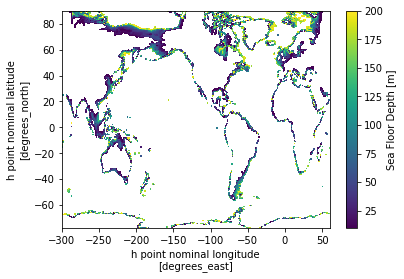

In [49]:
grid.deptho.where(grid.deptho.values <= 200).plot()

Text(0.5, 1.0, 'Large Tunicates')

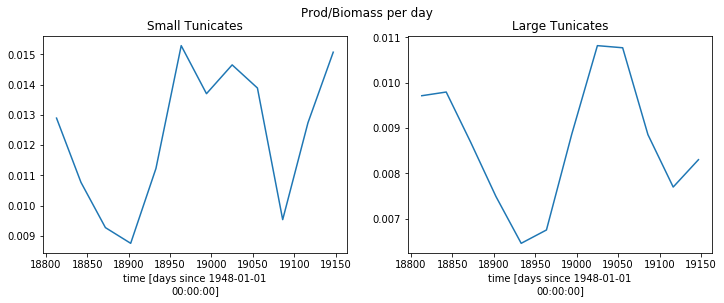

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Prod/Biomass per day')

pb_smt.mean(dim=['xh','yh']).plot(ax=ax1)
ax1.set_title('Small Tunicates')

pb_lgt.mean(dim=['xh','yh']).plot(ax=ax2)
ax2.set_title('Large Tunicates')

Text(0.5, 1.0, 'Large Zooplankton')

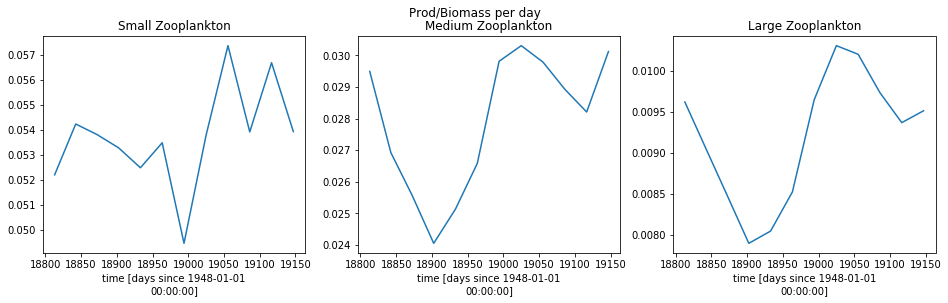

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Prod/Biomass per day')

pb_smz.mean(dim=['xh','yh']).plot(ax=ax1)
ax1.set_title('Small Zooplankton')

pb_mdz.mean(dim=['xh','yh']).plot(ax=ax2)
ax2.set_title('Medium Zooplankton')

pb_lgz.mean(dim=['xh','yh']).plot(ax=ax3)
ax3.set_title('Large Zooplankton')

Text(0.5, 1.0, 'Large Tunicates')

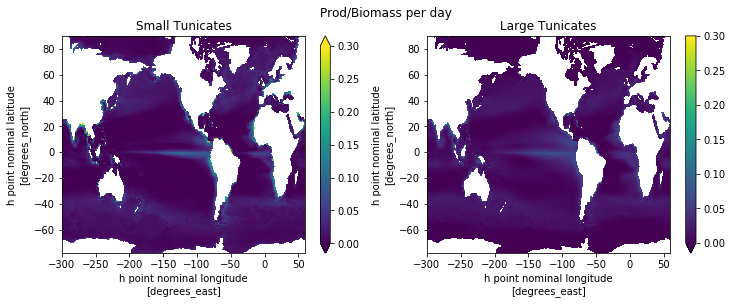

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Prod/Biomass per day')

pb_smt.mean(dim=['time']).plot(ax=ax1, vmin=0, vmax=0.3)
ax1.set_title('Small Tunicates')

pb_lgt.mean(dim=['time']).plot(ax=ax2, vmin=0, vmax=0.3)
ax2.set_title('Large Tunicates')

Text(0.5, 1.0, 'Large Zooplankton')

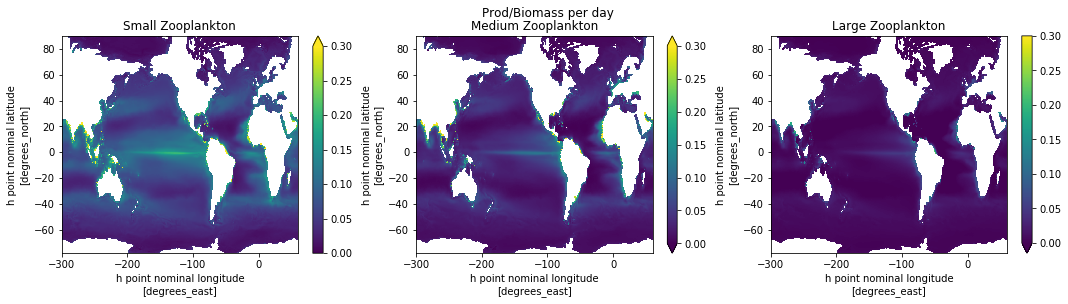

In [106]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
fig.suptitle('Prod/Biomass per day')

pb_smz.mean(dim=['time']).plot(ax=ax1, vmin=0,vmax=0.3)
ax1.set_title('Small Zooplankton')

pb_mdz.mean(dim=['time']).plot(ax=ax2, vmin=0,vmax=0.3)
ax2.set_title('Medium Zooplankton')

pb_lgz.mean(dim=['time']).plot(ax=ax3, vmin=0,vmax=0.3)
ax3.set_title('Large Zooplankton')

Text(0.5, 1.0, 'Large Tunicates')

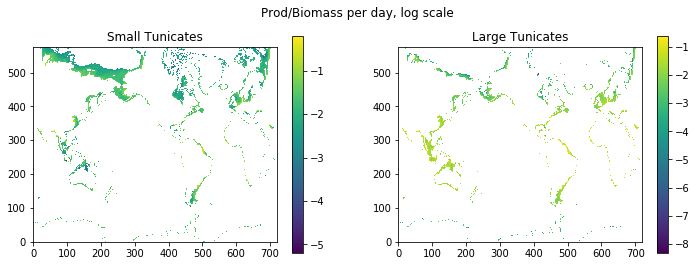

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Prod/Biomass per day, log scale')

f1=ax1.imshow(np.log10(pb_smt.where(grid.deptho.values <= 200).mean(dim=['time']).values), origin='bottom')
fig.colorbar(f1, ax=ax1)
ax1.set_title('Small Tunicates')

f2=ax2.imshow(np.log10(pb_lgt.where(grid.deptho.values <= 200).mean(dim=['time']).values), origin='bottom')
fig.colorbar(f2, ax=ax2)
ax2.set_title('Large Tunicates')

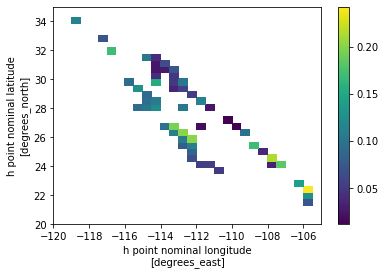

In [70]:
pb_smt.where(grid.deptho.values <= 200).where(pb_smt.yh < 35).where(pb_smt.yh > 20).where(pb_smt.xh < -105).where(pb_smt.xh > -120).mean(dim=['time']).plot(xlim=(-120,-105),ylim=(20,35))
#pb_smt.where(pb_smt.yh < 35).where(pb_smt.yh > 20).where(pb_smt.xh < -105).where(pb_smt.xh > -120).mean(dim=['time']).plot(xlim=(-120,-105),ylim=(20,35))

Text(0.5, 1.0, 'Large Tunicates')

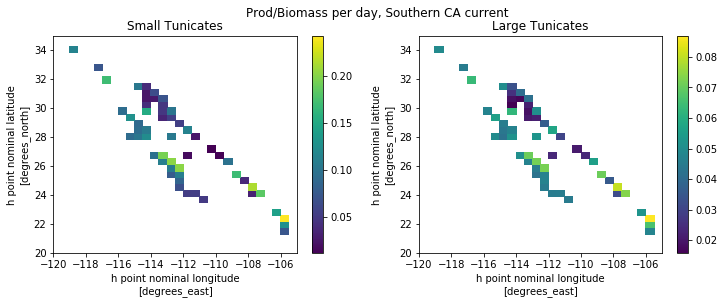

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Prod/Biomass per day, Southern CA current')

pb_smt.where(grid.deptho.values <= 200).where(pb_smt.yh < 35).where(pb_smt.yh > 20).where(pb_smt.xh < -105).where(pb_smt.xh > -120).mean(dim=['time']).plot(ax=ax1, xlim=(-120,-105),ylim=(20,35))
ax1.set_title('Small Tunicates')

pb_lgt.where(grid.deptho.values <= 200).where(pb_smt.yh < 35).where(pb_smt.yh > 20).where(pb_smt.xh < -105).where(pb_smt.xh > -120).mean(dim=['time']).plot(ax=ax2, xlim=(-120,-105),ylim=(20,35))
ax2.set_title('Large Tunicates')

Text(0.5, 1.0, 'Large Tunicates')

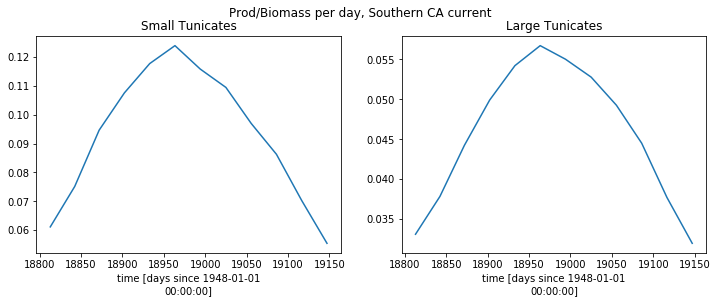

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Prod/Biomass per day, Southern CA current')

pb_smt.where(grid.deptho.values <= 200).where(pb_smt.yh < 35).where(pb_smt.yh > 20).where(pb_smt.xh < -105).where(pb_smt.xh > -120).mean(dim=['xh','yh']).plot(ax=ax1)
ax1.set_title('Small Tunicates')

pb_lgt.where(grid.deptho.values <= 200).where(pb_smt.yh < 35).where(pb_smt.yh > 20).where(pb_smt.xh < -105).where(pb_smt.xh > -120).mean(dim=['xh','yh']).plot(ax=ax2)
ax2.set_title('Large Tunicates')